In [2]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import ops 
from utils import *
import cv2
%load_ext autoreload
%autoreload 2
%pylab inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'random', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [3]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=1024 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [4]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

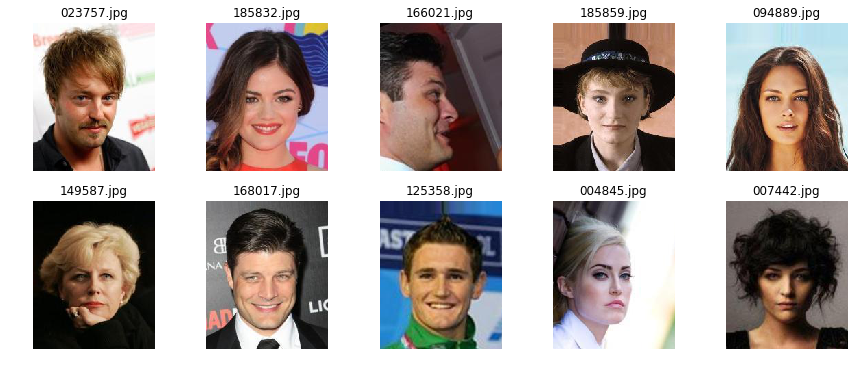

In [5]:
def visualize_samples(data_path, n_cols=5, n_rows=2,crop=False):
    """Visualize samples."""
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.randint(len(os.listdir(data_path)), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img=plt.imread(data_path+os.listdir(data_path)[i])
        plt.title(os.listdir(data_path)[i])
        if not crop:
            plt.imshow(img)
        else:
            plt.imshow(crop_and_scale(img))
    plt.show()
visualize_samples(DATA_PATH)

In [6]:
#center crop to 150*120 and resize to 64,64 the images to make them more manageable
def crop_and_scale(img):
    cropped_img=img[34:184,29:149]
    return cv2.resize(cropped_img,(64,64))

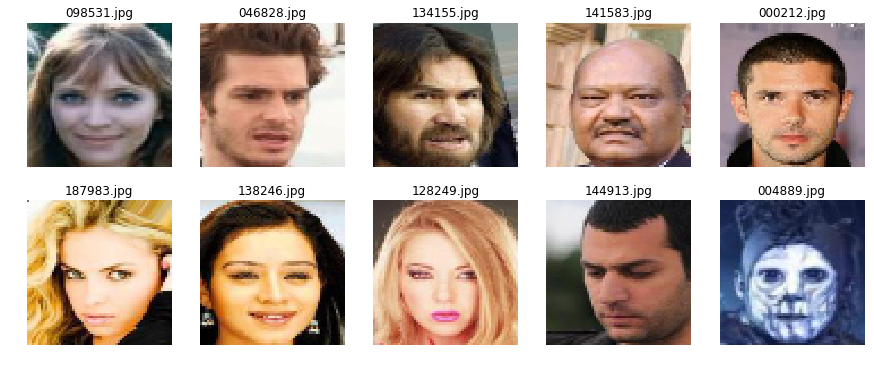

In [7]:
visualize_samples(DATA_PATH,crop=True) #looks ok

In [8]:
def transform(arr):
    arr=arr/127.5-1.
    return arr

def get_image_batch(data_path,batch_size=32):
    ret_arr=[]
    for i in np.random.randint(len(os.listdir(data_path)), size = batch_size):
        img=transform(crop_and_scale(plt.imread(data_path+os.listdir(data_path)[i])))
        ret_arr.append(img)
    return np.array(ret_arr)


Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [9]:

def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    
    z_ = ops.linear(z, GENERATOR_DENSE_SIZE*4*4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    g_batch_norm_in=ops.batch_norm(name='g_batch_norm_in')
    h_in_bn = g_batch_norm_in(h_in,is_training)
    h_in_z=ops.lrelu(x=h_in_bn,name='g_lr_1')

    h_1=ops.deconv2d(h_in_z,output_shape=[BATCH_SIZE,8,8,512],k_h=5,k_w=5,d_h=2, d_w=2,name="g_deconv_1")
    g_batch_norm_1=ops.batch_norm(name='g_batch_norm_1')
    h_1_bn = g_batch_norm_1(h_1,is_training)
    h_1_z=ops.lrelu(x=h_1_bn,name='g_lr_2')
    h_1_z_dr=tf.nn.dropout(h_1_z,0.3)

    h_2=ops.deconv2d(h_1_z_dr,output_shape=[BATCH_SIZE,16,16,256],k_h=5,k_w=5,d_h=2, d_w=2,name="g_deconv_2")
    g_batch_norm_2=ops.batch_norm(name='g_batch_norm_2')
    h_2_bn = g_batch_norm_2(h_2,is_training)
    h_2_z=ops.lrelu(x=h_2_bn,name='g_lr_3')
    h_2_z_dr=tf.nn.dropout(h_2_z,0.3)

    h_3=ops.deconv2d(h_2_z_dr,output_shape=[BATCH_SIZE,32,32,128],k_h=5,k_w=5,d_h=2, d_w=2,name="g_deconv_3")
    g_batch_norm_3=ops.batch_norm(name='g_batch_norm_3')
    h_3_bn = g_batch_norm_3(h_3,is_training)
    h_3_z=ops.lrelu(x=h_3_bn,name='g_lr_4')

    h_out = ops.deconv2d(h_3_z, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)


Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [10]:
def discriminator(image, is_training, batch_norms=None):

    dh_in = ops.conv2d(image,output_dim=32,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_1")
    d_batch_norm_1=ops.batch_norm(name='d_batch_norm_1')
    dh_in_bn = d_batch_norm_1(dh_in,is_training)
    dh_in_z=ops.lrelu(x=dh_in_bn,name='d_lr_1')
    
    dh_1=ops.conv2d(dh_in_z,output_dim=64,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_2")
    d_batch_norm_2=ops.batch_norm(name='d_batch_norm_2')
    dh_1_bn = d_batch_norm_2(dh_1,is_training)
    dh_1_z=ops.lrelu(x=dh_1_bn,name='d_lr_2')

    dh_2=ops.conv2d(dh_1_z,output_dim=128,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_3")
    d_batch_norm_3=ops.batch_norm(name='d_batch_norm_3')
    dh_2_bn =d_batch_norm_3(dh_2,is_training)
    dh_2_z=ops.lrelu(x=dh_2_bn,name='d_lr_3')

    dh_3=ops.conv2d(dh_2_z,output_dim=256,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_4")
    d_batch_norm_4=ops.batch_norm(name='d_batch_norm_4')
    dh_3_bn =d_batch_norm_4(dh_3,is_training)
    dh_3_z=ops.lrelu(x=dh_3_bn,name='d_lr_4')

    dh_4=ops.conv2d(dh_3_z,output_dim=512,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_5")
    d_batch_norm_5=ops.batch_norm(name='d_batch_norm_5')
    dh_4_bn =d_batch_norm_5(dh_4,is_training)
    dh_4_z=ops.lrelu(x=dh_4_bn,name='d_lr_5')

    d_flat=tf.contrib.layers.flatten(dh_3_z)

    d_linear=ops.linear(d_flat, 256, 'd_lin_1')
    d_batch_norm_6=ops.batch_norm(name='d_batch_norm_6')
    d_linear_bn=d_batch_norm_6(d_linear,is_training)
    d_linear_z=ops.lrelu(x=d_linear_bn,name='d_lr_6')


    linear_out=ops.linear(d_linear_z,1,'d_lin_out')

    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [11]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    #scope.reuse_variables()
    G = generator(z, is_training)
    
with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)   

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [12]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = -tf.reduce_mean(tf.log_sigmoid(D_real_logits))

d_loss_fake = -tf.reduce_mean(tf.log(1-D_fake+1e-30))

surity1=np.random.uniform(0.8,1.15) #label smoothing
surity2=np.random.uniform(-1.0,0.2)

d_loss = surity1*d_loss_real + (1-surity2)*d_loss_fake

g_loss = -tf.reduce_mean(tf.log_sigmoid(D_fake_logits))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [13]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [14]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
print(len(data))
assert(len(data) > 0), "Length of training data should be more than zero"

186513


Functions for training and evaluations.

In [15]:
def load(sess, load_dir,latest_fname=None):
    """load network's paramaters                                                                                                                                                  
                                                                                                                                                                                  
    load_dir : path to load dir                                                                                                                                                   
    """
    saver = tf.train.Saver()
    #    ckpt = tf.train.get_checkpoint_state(load_dir,latest_filename=latest_fname)                                                                                              
    #   if ckpt and ckpt.model_checkpoint_path:                                                                                                                                   
    #          saver.restore(sess, ckpt.model_checkpoint_path)                                                                                                                    
    saver.restore(sess,os.path.join(load_dir,latest_fname))

## Training GAN (1 point + 2 for good results)

In [107]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs =100# min(len(data), np.inf) // BATCH_SIZE
        
        for idx in range(batch_idxs):
           # batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
           #batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
           # batch_images = np.array(batch).astype(np.float32)
            batch_images=get_image_batch(DATA_PATH,BATCH_SIZE)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_X],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sampled")

In [108]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint',sample_frequency=2,model_name='dcgan.model',n_epochs=1)#just test here, do rest of training on university gpu cluster

Epoch: [ 0] [   0/ 100] time: 45.2493, d_loss: 1.38503718, g_loss: 0.67893845
Epoch: [ 0] [   1/ 100] time: 80.7847, d_loss: 1.38591862, g_loss: 0.67743587
Sampled
Epoch: [ 0] [   2/ 100] time: 119.2346, d_loss: 1.38833427, g_loss: 0.67864835
Epoch: [ 0] [   3/ 100] time: 153.9000, d_loss: 1.38968706, g_loss: 0.67567158
Sampled
Epoch: [ 0] [   4/ 100] time: 191.9952, d_loss: 1.38841128, g_loss: 0.66945529
Epoch: [ 0] [   5/ 100] time: 226.8364, d_loss: 1.39014482, g_loss: 0.65842140
Sampled
Epoch: [ 0] [   6/ 100] time: 269.0626, d_loss: 1.38317680, g_loss: 0.65497071
Epoch: [ 0] [   7/ 100] time: 303.6702, d_loss: 1.38315177, g_loss: 0.64368576
Sampled
Epoch: [ 0] [   8/ 100] time: 342.7040, d_loss: 1.38708949, g_loss: 0.63261092
Epoch: [ 0] [   9/ 100] time: 386.0408, d_loss: 1.36927140, g_loss: 0.62037337
Sampled
Epoch: [ 0] [  10/ 100] time: 432.8635, d_loss: 1.35803175, g_loss: 0.61230111
Epoch: [ 0] [  11/ 100] time: 468.6063, d_loss: 1.33568513, g_loss: 0.60330868
Sampled
Epoch:

Sampled
Epoch: [ 0] [  98/ 100] time: 3644.1605, d_loss: 1.21231341, g_loss: 0.51537979
Epoch: [ 0] [  99/ 100] time: 3678.9370, d_loss: 1.38970625, g_loss: 0.41536263
Saved model
Sampled


In [109]:
sess=tf.Session()#load weights from training on gpu cluster, trained for about 30 epochs
load(sess, load_dir='checkpoint',latest_fname='dcgan.model_30001')

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model_30001


INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model_30001


### Lets  generate some new samples and look at them. They look very much like faces.

In [38]:
#generate some new samples
new_samples=100# 100 batches
counter=0
for idx in range(new_samples):
    
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    for sample in samples:
        plt.imsave("new_samples/new_sample"+str(counter), (255*inverse_transform(sample)).astype(np.uint8))
        counter+=1

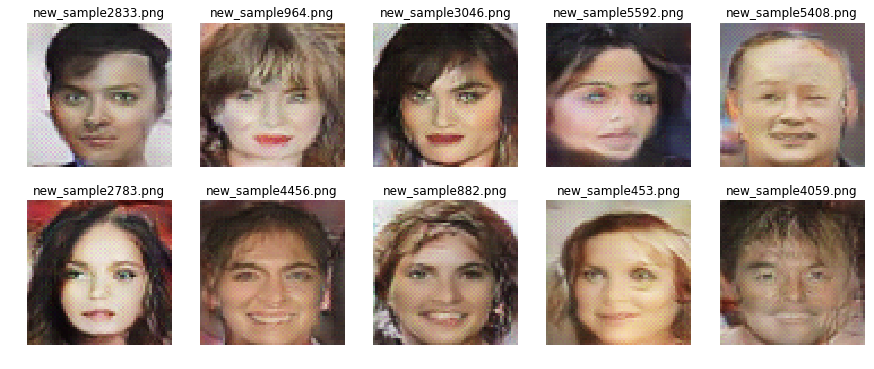

In [41]:
#look at random generated samples
visualize_samples('./new_samples/',crop=False)

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

### We first generate two random images z1, and z2. We then interpolate their z using the smearing formula above using a uniformly distributed alpah between 0 and 1. We then look at images generated using z1 and z2 along with all the interpolated images. At alpha close to zero image looks like z2 as expected and gradually starts looking like z1 and at alpha close to1 becomes almost exactly like z1. 

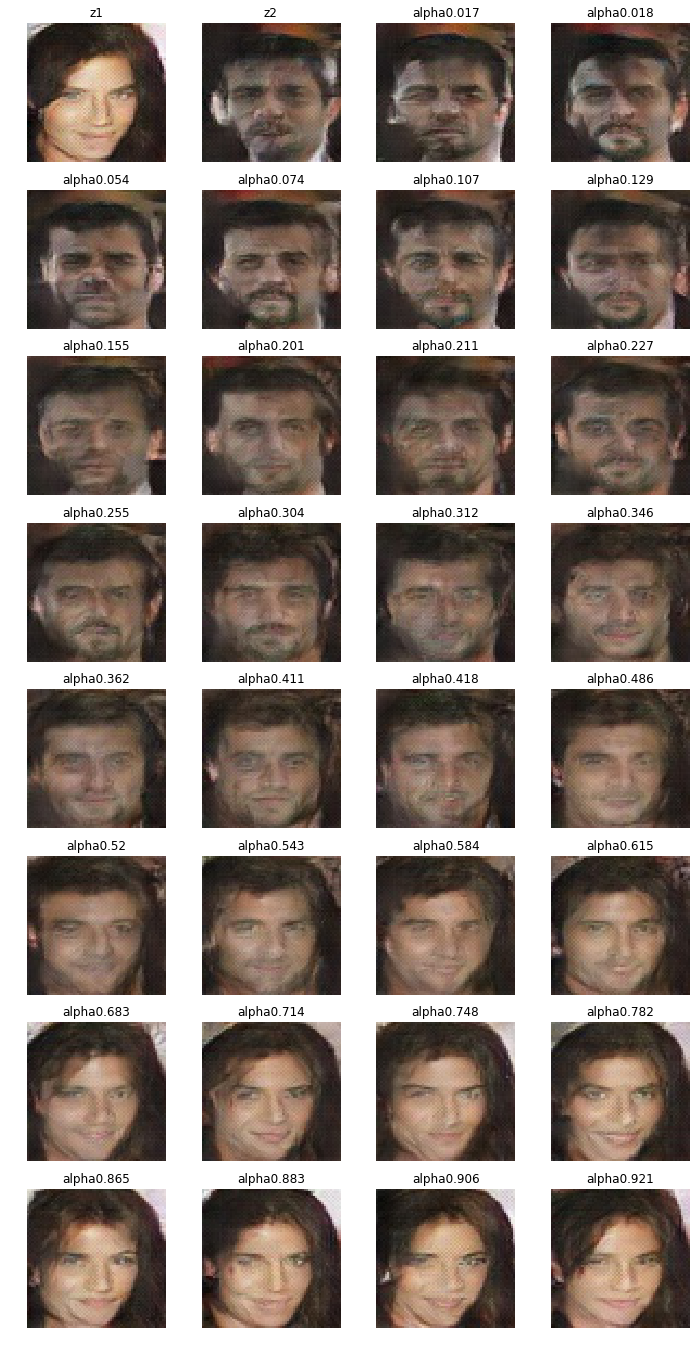

In [105]:
!rm interpolated_samples/*
batch_z_template = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
alpha=np.sort(np.random.uniform(high=1,low=0,size=62))
for i in range(62):
    batch=alpha[i]*batch_z_template[0]+(1-alpha[i])*batch_z_template[1]
    batch_z_template=np.vstack([batch_z_template,batch])

samples = sess.run(G, feed_dict={z: batch_z_template, is_training: False} )
for i in range(len(samples)):
    if i==0:
        plt.imsave("interpolated_samples/z1.jpg", (255*inverse_transform(samples[i])).astype(np.uint8))
    elif i==1:
        plt.imsave("interpolated_samples/z2.jpg", (255*inverse_transform(samples[i])).astype(np.uint8))
    else:
        plt.imsave("interpolated_samples/alpha"+str(round(alpha[i-2],3))+".jpg",(255*inverse_transform(samples[i])).astype(np.uint8))

names=['z1.jpg','z2.jpg']+["alpha"+str(round(alpha[i],3))+".jpg" for i in range(len(alpha)) if i%2==0]
plt.figure(figsize = (12,24))
for j in range(len(names)-1):
    plt.subplot(8,4,j+1)
    plt.axis('off')
    img=plt.imread("interpolated_samples/"+names[j])
    plt.title(names[j].replace('.jpg',''))
    plt.imshow(img)
plt.show()
    

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

### Here we generate some random images and pick  some smiling and non-smiling ones manually

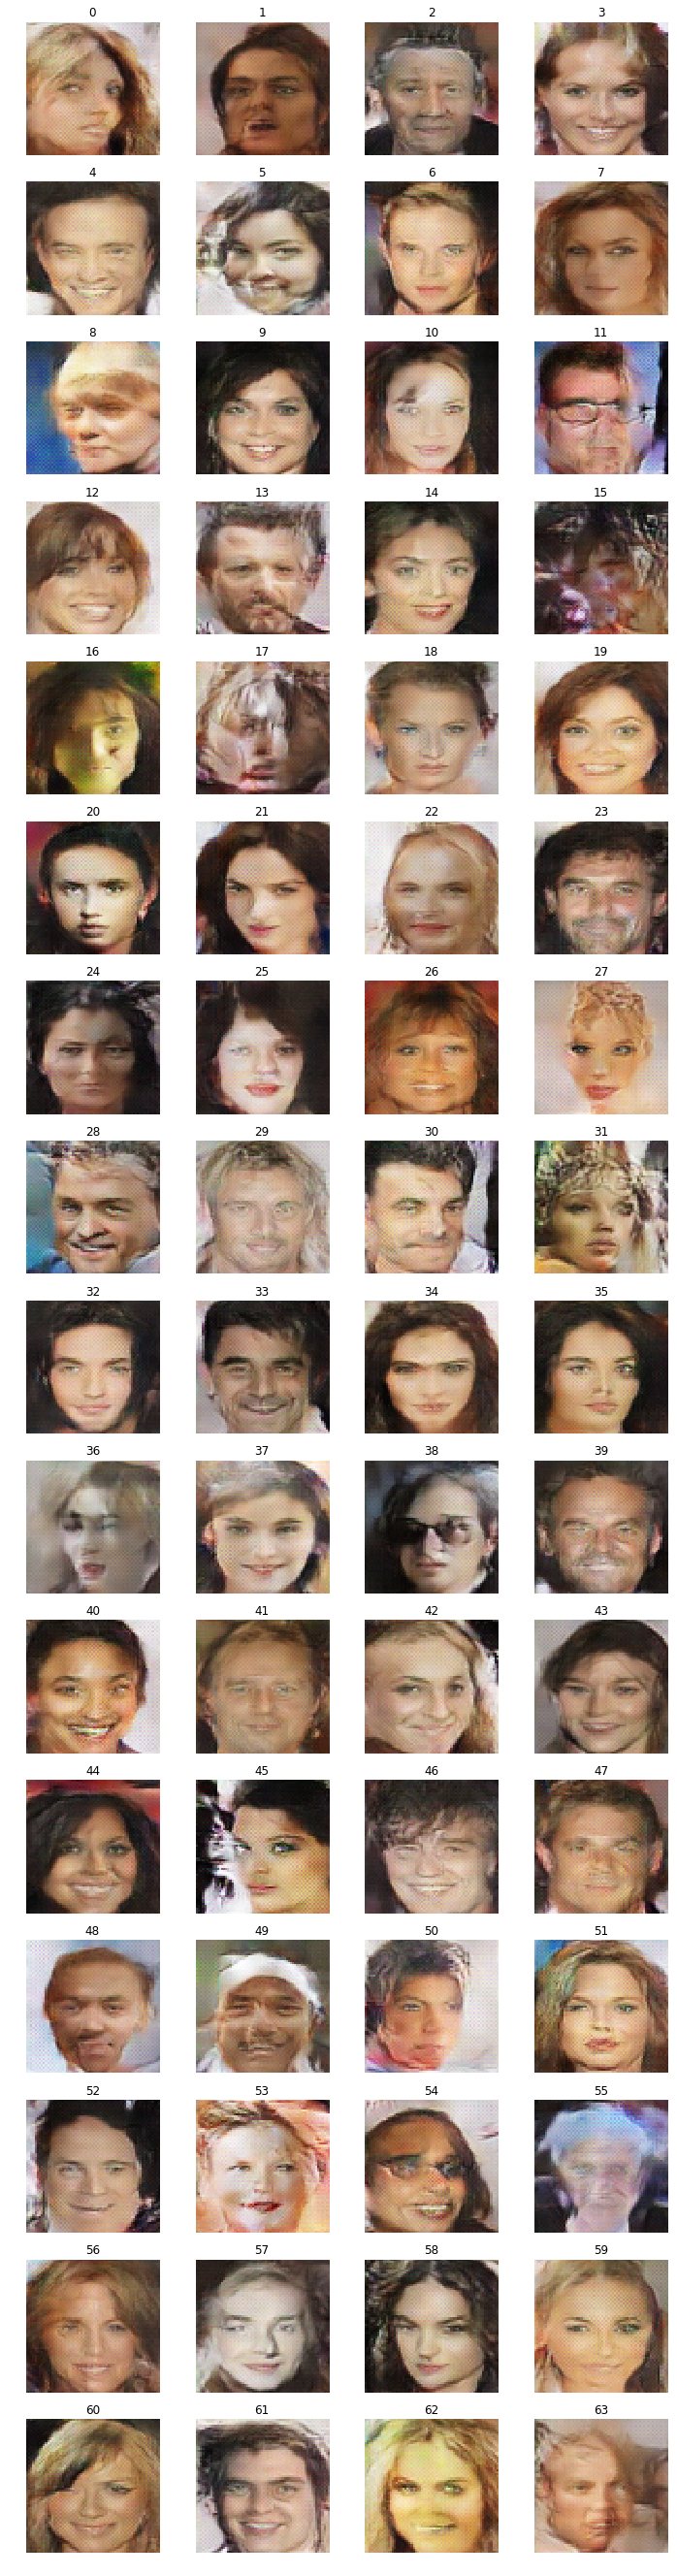

In [60]:
#batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
plt.figure(figsize = (12,48))
for j in range(len(samples)):
    plt.subplot(16,4,j+1)
    plt.axis('off')
    plt.title(str(j))
    plt.imshow((255*inverse_transform(samples[j])).astype(np.uint8))
plt.show()

### Here we take the mean of the smiling z vectors and that of the non-smiling ones. Then we calculate the difference as the smile vector and then apply that to the no smiling ones.

In [101]:
smiles=[3,4,9,12,14,19,28,39,33,40,46,44,61]
no_smiles=[6,11,18,20,24,38,2,35]
smile_mean=np.zeros_like(batch_z[0])

for smile in smiles:
    smile_mean+=batch_z[smile]
smile_mean/=len(smiles)
no_smile_mean=np.zeros_like(batch_z[0])
for no_smile in no_smiles:
    no_smile_mean+=batch_z[no_smile]
no_smile_mean/=len(no_smiles)

smile_vector=smile_mean-no_smile_mean

added_smile_z=batch_z+smile_vector
added_smile_z=np.clip(a=added_smile_z,a_max=1.0,a_min=-1.0)

added_smile_samples=sess.run(G, feed_dict={z: added_smile_z, is_training: False} )


### Finally we look at the original non-smiling images and the ones after adding smiling z-vector to their generative code. 
### Itappears we cheered them up somewhat :-)

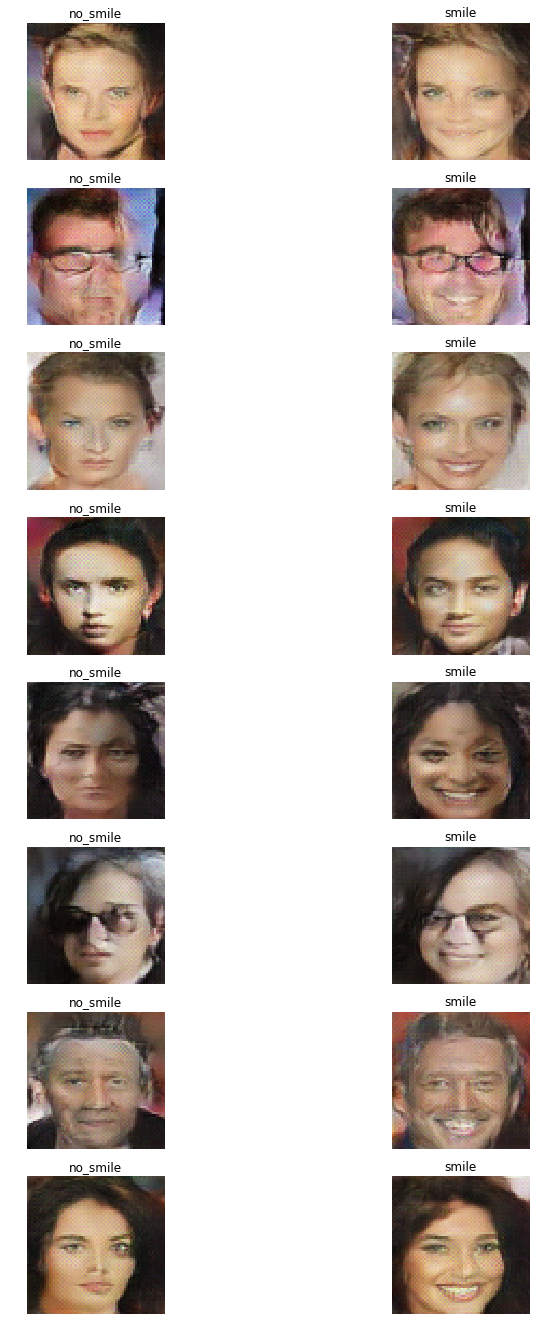

In [100]:

plt.figure(figsize = (12,48))
counter=1
for j in no_smiles:
    plt.subplot(16,2,counter)
    plt.axis('off')
    plt.title("no_smile")
    plt.imshow((255*inverse_transform(samples[j])).astype(np.uint8))
    counter+=1
    plt.subplot(16,2,counter)
    plt.axis('off')
    plt.title("smile")
    plt.imshow((255*inverse_transform(added_smile_samples[j])).astype(np.uint8))
    counter+=1
plt.show()


If faces looks really cool, add bonus 1 point to your score.